# Logistic regression with Tensorflow Probability

In [1]:
############ EJECUTAR EN COLAB

In [2]:
# !pip install tensorflow
# !pip install tensorflow_probability==0.8.0rc0
# ! pip3 install -q --upgrade tensorflow-probability==0.8.0
# !pip install arviz
# !pip install tfp-nightly 0.11.0.dev20200708

## 0. Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import arviz as az

# TensorFlow imports
import tensorflow as tf
"""
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()
"""

import tensorflow_probability as tfp

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'
plt.style.use('seaborn-darkgrid')

tfd = tfp.distributions
tfb = tfp.bijectors

ModuleNotFoundError: No module named 'tensorflow'

## 1. Binary univariate classification

In [4]:
N = 50
K=1

In [5]:
x1 = np.random.normal(2.5, 1, N)
x2 = np.random.normal(4, 1, N)
data = pd.DataFrame([x1, x2]).T
data.head()

,0,1
0,2.736765,3.708597
1,2.698802,3.343554
2,1.371128,4.912769
3,2.186100,2.738506
4,2.646724,3.322161


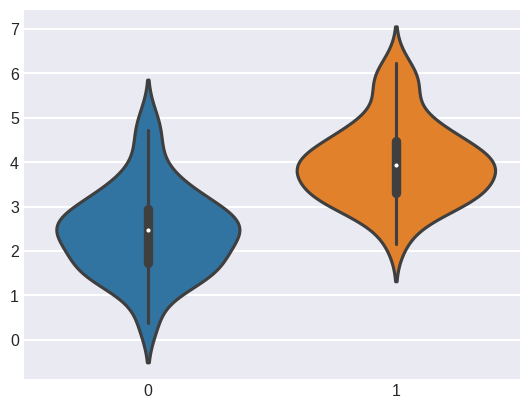

In [6]:
sns.violinplot(data=data)
plt.show()

In [7]:
x_0 = np.concatenate([x1, x2]).reshape((2*N, 1))
y_0 = np.concatenate([np.zeros(N), np.ones(N)]).astype(int)

In [8]:
# Model definition

def joint_log_prob(X_data_, Y_data_, alpha, beta):
    
    # create random variables for priors for alpha and beta
    rv_beta = tfd.Normal(name="beta", loc=0., scale=10.)
    rv_alpha = tfd.Normal(name="alpha", loc=0., scale=10.)
    
    logistic_p = 1.0/(1. + tf.exp(beta * X_data_ + alpha))
    rv_observed = tfd.Bernoulli(probs=logistic_p)
    
    return (
        rv_alpha.log_prob(alpha) 
        + rv_beta.log_prob(beta) 
        + tf.reduce_sum(rv_observed.log_prob(Y_data_))
    )

In [9]:
# Sampling from Hamiltonian Monte Carlo

number_of_steps = 4000
burnin = 800

# Set the chain's start state.
initial_chain_state = [
    tf.cast(x=1.,dtype=tf.float32) * tf.ones([], name='init_alpha', dtype=tf.float32),
    tf.cast(x=1,dtype=tf.float32) * tf.ones([], name='init_beta', dtype=tf.float32)
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),
    tfp.bijectors.Identity()
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(x_0, y_0, *args)

# Initialize the step_size. (It will be automatically adapted.)
with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
    step_size = tf.compat.v1.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )
    
# Initialize the step_size_adaptation_step_counter, else you get TF error messages
with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
    step_size_adaptation_step_counter = tf.compat.v1.get_variable(
        name='step_size_adaptation_step_counter',
        initializer=tf.constant(0.0, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )    
    # Defining the HMC
    hmc=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            num_leapfrog_steps=2,
            step_size=step_size,
            step_size_update_fn= tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin*0.9)),
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors)

# Sampling from the chain.
[
    posterior_alpha,
    posterior_beta
], kernel_results = tfp.mcmc.sample_chain(
    num_results = number_of_steps,
    num_burnin_steps = burnin, # HMC gets rid of our burnin iterations automatically
    current_state=initial_chain_state,
    kernel=hmc,
    name='HMC_sampling'
)

# Initialize any created variables for preconditions
init_g = tf.compat.v1.global_variables_initializer()

Instructions for updating:
Use tfp.mcmc.SimpleStepSizeAdaptation instead.


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:370: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  param_name))
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [10]:
# Evaluating the graph generated above

def evaluate(tensors):
    if tf.executing_eagerly():
         return tf.nest.pack_sequence_as(
             tensors,
             [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    with tf.Session() as sess:
        return sess.run(tensors)
    
#print(tf.executing_eagerly())

evaluate(init_g)

[
    posterior_alpha_,
    posterior_beta_,
    kernel_results_
] = evaluate([
    posterior_alpha,
    posterior_beta,
    kernel_results
])

print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.67025
final step size: 0.00952934566885233


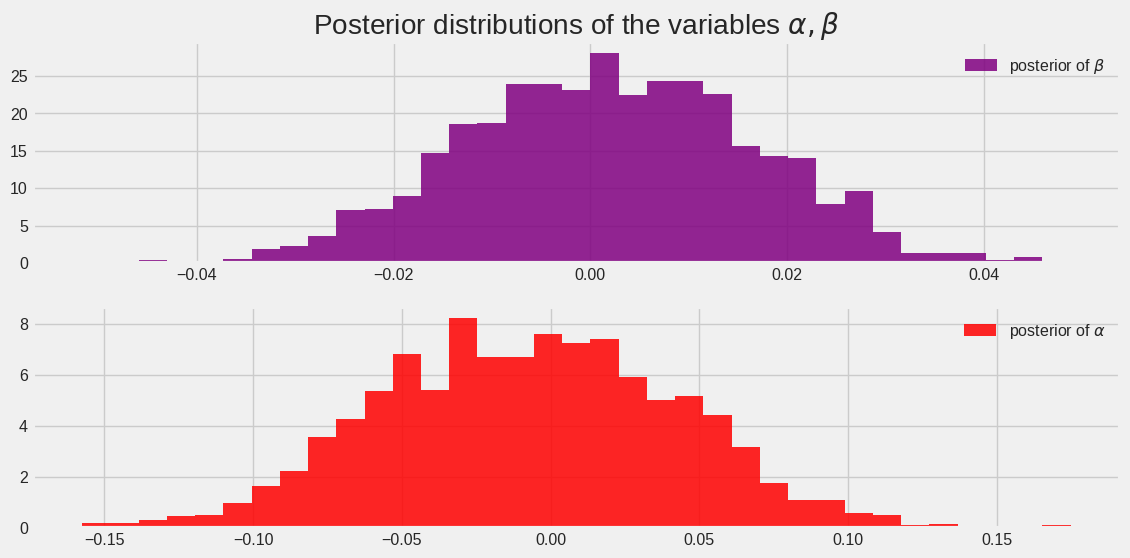

In [11]:
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from IPython.core.pylabtools import figsize

plt.figure(figsize(12.5, 6))

plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(posterior_beta_, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color='purple', density=True)
plt.legend()

plt.subplot(212)
plt.hist(posterior_alpha_, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color='red', density=True)
plt.legend()
plt.show()

In [12]:
trace_posterior_alpha = posterior_alpha_[burnin:]
trace_posterior_beta = posterior_beta_[burnin:]

inference_data = az.convert_to_inference_data({
    'p_alpha': tf.transpose(trace_posterior_alpha),
    'p_beta': tf.transpose(trace_posterior_beta)
})

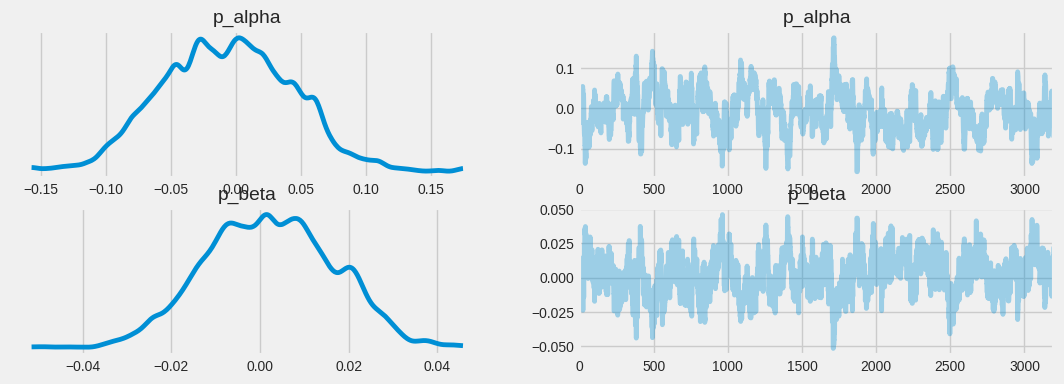

In [13]:
az.plot_trace(inference_data)
plt.show()

In [14]:
az.summary(inference_data)

arviz - WARNING - Shape validation failed: input_shape: (1, 3200), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_alpha,-0.007,0.050,-0.103,0.076,0.005,0.004,84.0,217.0,NaN
p_beta,0.002,0.015,-0.025,0.028,0.002,0.001,95.0,262.0,NaN
